In [1]:
import pandas as pd
import numpy as np

In [2]:
import os


import warnings
from warnings import simplefilter
os.getcwd()


'/home/m/repo/ThinkBayes2/mine'

In [48]:
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

def check_complete_index(df, freq='H'):
    # Create a complete datetime index
    complete_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)

    # Check if the datetime index of df has any missing timestamps
    missing_timestamps = complete_index.difference(df.index)

    if missing_timestamps.empty:
        print("There are no missing timestamps in the datetime index.")
    else:
        print(f"There are {len(missing_timestamps)} missing timestamps in the datetime index.")

In [4]:
import pandas as pd
from pathlib import Path

data_folder = Path('data')

dm = pd.read_csv(data_folder / 'price_dm.csv', parse_dates=['Date_Time'])
dm.columns = dm.columns.str.lower()
dm['date_time'] = dm['date_time'].dt.tz_localize(None)
dm.set_index('date_time', inplace=True)
dm.head()


,price_si,da_prob_catboost,da_prob_glmnet,da_prob_gp,da_prob_lgbm,da_prob_svm,da_prob_xgb,price_dm,price_dm_forecast,da_prob_truth,...,price_si_formula,k_price_positive_imbalance_threshold,k_price_negative_imbalance_threshold,return_unit,return_unit_expected,return_percentage,return_percentage_formula,return_percentage_expected,probability,da_grid_clf
date_time,,,,,,,,,,,,,,,,,,,,,
2021-12-31 23:00:00,-27.22,0.590285,0.562772,0.452133,0.580919,0.350477,0.544092,50.05,51.0733,0,...,-27.22,27.22,27.22,-1.93175,-0.783710,-1.543856,-1.543856,-0.613792,0.452133,DA_prob_gp
2021-12-31 23:15:00,-27.22,0.336310,0.296826,0.255633,0.232713,0.292439,0.227383,50.05,51.0733,0,...,-27.22,27.22,27.22,-1.93175,-1.293774,-1.543856,-1.543856,-1.013268,0.255633,DA_prob_gp
2021-12-31 23:30:00,-27.22,0.104664,0.143188,0.214134,0.118835,0.321807,0.084947,50.05,51.0733,0,...,-27.22,27.22,27.22,-1.93175,-1.401496,-1.543856,-1.543856,-1.097635,0.214134,DA_prob_gp
2021-12-31 23:45:00,-27.22,0.112824,0.063401,0.172168,0.140791,0.210319,0.104256,50.05,51.0733,0,...,-27.22,27.22,27.22,-1.93175,-1.510427,-1.543856,-1.543856,-1.182949,0.172168,DA_prob_gp
2022-01-01 00:00:00,-27.22,0.383816,0.449963,0.449254,0.303342,0.304381,0.429335,41.33,34.2244,0,...,-27.22,27.22,27.22,-1.71375,-0.653813,-1.658602,-1.658602,-0.764149,0.449254,DA_prob_gp


In [5]:
features = ['price_dm', 'price_dm_forecast']
dm_hour = dm[features].resample('H').mean()
dm_hour = dm_hour.interpolate(method='linear')
dm_days = dm_hour.resample('D').mean()

In [6]:
dm_hour.isna().sum()

price_dm             0
price_dm_forecast    0
dtype: int64

In [7]:
split_index = int(len(dm_days) * 3/4)
split_date = dm_days.index[split_index]

In [8]:
train_data = dm_hour[:split_date - pd.Timedelta(hours=1)]
test_data = dm_hour[split_date:]

In [9]:
import plotly.graph_objs as go

def log_transform(x):
    return(np.where(x > 0, np.log(x), 0))

def identity(x):
    return(x)

transf_vec = np.vectorize(identity)

train_trace = go.Scatter(x=train_data.index, y=transf_vec(train_data['price_dm'].values), name='Train', line=dict(color='green'))
test_trace = go.Scatter(x=test_data.index, y=transf_vec(test_data['price_dm'].values), name='Test', line=dict(color='blue'))
layout = go.Layout(title='Train/Test Data', xaxis=dict(title='Date'), yaxis=dict(title='Value'))

In [10]:
traces = [train_trace, test_trace]
fig = go.Figure(data=traces, layout=layout)
fig.show()

In [11]:
train_data

,price_dm,price_dm_forecast
date_time,,
2021-12-31 23:00:00,50.05,51.0733
2022-01-01 00:00:00,41.33,34.2244
2022-01-01 01:00:00,43.22,38.5626
2022-01-01 02:00:00,45.46,20.7972
2022-01-01 03:00:00,37.67,43.6314
...,...,...
2022-12-20 19:00:00,248.63,273.3000
2022-12-20 20:00:00,229.49,206.0939
2022-12-20 21:00:00,207.72,181.5379


In [12]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

ets_params = {
    # 'trend': 'add',
    # 'damped_trend': True,
    'seasonal': 'add',
    'seasonal_periods': 24*7*4,
    'initialization_method': 'heuristic'
}

optim_params = {
    'maxiter': 10000,
    # 'pgtol': 1e-5
}

X = train_data['price_dm'].squeeze()
fit = ETSModel(X, **ets_params).fit(**optim_params)

fit.summary()

# lowest AIC or BIC value.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.32089D+00    |proj g|=  8.99900D-01

At iterate    1    f=  4.87506D+00    |proj g|=  2.42807D-01

At iterate    2    f=  4.87293D+00    |proj g|=  1.35514D-01

At iterate    3    f=  4.86815D+00    |proj g|=  4.35690D-02

At iterate    4    f=  4.86768D+00    |proj g|=  1.70895D-02

At iterate    5    f=  4.86759D+00    |proj g|=  1.10307D-02

At iterate    6    f=  4.86744D+00    |proj g|=  1.00656D-02

At iterate    7    f=  4.86704D+00    |proj g|=  3.18038D-02

At iterate    8    f=  4.86649D+00    |proj g|=  4.71413D-02

At iterate    9    f=  4.86520D+00    |proj g|=  3.45513D-02

At iterate   10    f=  4.86496D+00    |proj g|=  1.17690D-02

At iterate   11    f=  4.86491D+00    |proj g|=  5.82089D-02

At iterate   12    f=  4.86470D+00    |proj g|=  5.87468D-03

At iterate   13    f=  4.8

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:               price_dm   No. Observations:                 8497
Model:                       ETS(ANA)   Log Likelihood              -41335.332
Date:                Thu, 20 Apr 2023   AIC                          82676.664
Time:                        12:19:51   BIC                          82697.807
Sample:                    12-31-2021   HQIC                         82683.879
                         - 12-20-2022   Scale                          983.893
Covariance Type:               approx                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.9532      0.011     83.384      0.000       0.931       0.976
smoothing_seasonal     0.0468      0.004     11.227      0.000       0.039       0.055
=====================================================
                     initialization method: heuristic
-----------------------------------------------------
initial_level                                194.6703
initial_seasonal.0                           -57.5416
initial_seasonal.1                           -62.9248
initial_seasonal.2                           -57.5540
initial_seasonal.3                           -51.8971
initial_seasonal.4                           -49.4673
initial_seasonal.5                           -31.2889
initial_seasonal.6                           -12.6932
initial_seasonal.7                             5.2649
initial_seasonal.8                            10.9235
initial_seasonal.9                             8.2262
initial_seasonal.10                           -1.2210
initial_seasonal.11                            0.6578
initial_seasonal.12                           -8.3403
initial_seasonal.13                          -21.2626
initial_seasonal.14                          -17.9255
initial_seasonal.15                           -3.1762
initial_seasonal.16                           -2.1373
initial_seasonal.17                           14.6639
initial_seasonal.18                           30.8957
initial_seasonal.19                           31.2497
initial_seasonal.20                           12.6132
initial_seasonal.21                          -10.6620
initial_seasonal.22                          -54.2340
initial_seasonal.23                          -28.9152
initial_seasonal.24                          -39.5712
initial_seasonal.25                          -55.6555
initial_seasonal.26                          -59.7801
initial_seasonal.27                          -65.5070
initial_seasonal.28                          -67.7115
initial_seasonal.29                          -68.6694
initial_seasonal.30                          -66.1378
initial_seasonal.31                          -68.8270
initial_seasonal.32                          -60.2332
initial_seasonal.33                          -58.5770
initial_seasonal.34                          -81.1533
initial_seasonal.35                          -79.3534
initial_seasonal.36                          -99.4715
initial_seasonal.37                         -101.8581
initial_seasonal.38                          -95.8829
initial_seasonal.39                          -71.1919
initial_seasonal.40                          -37.9228
initial_seasonal.41                            6.8410
initial_seasonal.42                           -0.9760
initial_seasonal.43                            6.2711
initial_seasonal.44                           -9.7235
initial_seasonal.45                          -22.6498
initial_seasonal.46                          -28.8584
initial_seasonal.47                          -36.206

In [13]:
days = np.unique(dm_hour.index.date)

In [49]:
def log_transform(x):
    return np.where(x>=0, np.log(x + 1), 0)

def inverse_log_transform(x):
    return np.exp(x) - 1

In [66]:
ets_params = {
    # 'trend': 'add',
    # 'damped_trend': True,
    'seasonal': 'add', # "add" additive seasonality (constant amplitude of seasonal fluctuations),  'mul' multiplicative seasonality (changing amplitude of seasonal fluctuations)
    'seasonal_periods': 24 * 7 * 4, # daily patterns 24 + weekly patterns 7 (weekdays) + monthly patterns 4 
    'initialization_method': 'heuristic'
}

X = dm_hour['price_dm'].squeeze()
log_X = pd.Series(log_transform(X), index=X.index)

log_X.isna().sum()

/home/m/miniconda3/envs/ThinkBayes2/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log



0

In [67]:
window = pd.Timedelta(hours=24)

# Find the last timestamp in log_X.index and add one day to it
last_timestamp = log_X.index[-1] + pd.Timedelta(days=1)

# Create a new index with hourly frequency, starting from the first timestamp in log_X.index and ending at the new last timestamp
new_index = pd.date_range(start=log_X.index[0], end=last_timestamp, freq='H')

# Re-create the ets_pred DataFrame with the updated index
ets_pred = pd.DataFrame(index=new_index, columns=['mean', 'pi_lower', 'pi_upper'])

for day in days[split_index:]:
    print(day)
    train_data = log_X[dm_hour.index.date < day]
    fit = ETSModel(train_data, **ets_params).fit(**optim_params, disp=False)
    pred = fit.get_prediction(start=max(train_data.index) + pd.Timedelta(hours=1), end=max(train_data.index) + window)
    pred_df = pred.summary_frame(alpha=0.05)
    
    # Fill the pre-allocated DataFrame with the predictions
    ets_pred.loc[pred_df.index] = inverse_log_transform(pred_df)

ets_pred.dropna().tail()

2022-12-21
2022-12-22
2022-12-23
2022-12-24
2022-12-25
2022-12-26
2022-12-27
2022-12-28
2022-12-29
2022-12-30
2022-12-31
2023-01-01
2023-01-02
2023-01-03
2023-01-04
2023-01-05
2023-01-06
2023-01-07
2023-01-08
2023-01-09
2023-01-10
2023-01-11
2023-01-12
2023-01-13
2023-01-14
2023-01-15
2023-01-16
2023-01-17
2023-01-18
2023-01-19
2023-01-20
2023-01-21
2023-01-22
2023-01-23
2023-01-24
2023-01-25
2023-01-26
2023-01-27
2023-01-28
2023-01-29
2023-01-30
2023-01-31
2023-02-01
2023-02-02
2023-02-03
2023-02-04
2023-02-05
2023-02-06
2023-02-07
2023-02-08
2023-02-09
2023-02-10
2023-02-11
2023-02-12
2023-02-13
2023-02-14
2023-02-15
2023-02-16
2023-02-17
2023-02-18
2023-02-19
2023-02-20
2023-02-21
2023-02-22
2023-02-23
2023-02-24
2023-02-25
2023-02-26
2023-02-27
2023-02-28
2023-03-01
2023-03-02
2023-03-03
2023-03-04
2023-03-05
2023-03-06
2023-03-07
2023-03-08
2023-03-09
2023-03-10
2023-03-11
2023-03-12
2023-03-13
2023-03-14
2023-03-15
2023-03-16
2023-03-17
2023-03-18
2023-03-19
2023-03-20
2023-03-21

,mean,pi_lower,pi_upper
2023-04-18 19:00:00,143.704663,30.868368,656.060304
2023-04-18 20:00:00,126.595789,26.078053,600.250209
2023-04-18 21:00:00,112.995034,22.331722,555.961355
2023-04-18 22:00:00,104.189767,19.780927,531.453967
2023-04-18 23:00:00,102.355436,18.723483,540.605458


In [68]:
dm_hour[dm_hour.index.date>=split_date]
ets_pred

merged_df = pd.concat([dm_hour[dm_hour.index.date >= split_date], ets_pred], axis=1)
merged_df.dropna(inplace=True)

check_complete_index(merged_df)
merged_df.tail()

There are no missing timestamps in the datetime index.


,price_dm,price_dm_forecast,mean,pi_lower,pi_upper
2023-04-18 17:00:00,130.46,159.9680,168.880119,39.407059,713.213195
2023-04-18 18:00:00,135.24,154.9960,165.772708,37.150723,728.032995
2023-04-18 19:00:00,122.42,135.2588,143.704663,30.868368,656.060304
2023-04-18 20:00:00,110.71,125.4922,126.595789,26.078053,600.250209
2023-04-18 21:00:00,101.16,110.4968,112.995034,22.331722,555.961355


In [69]:
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

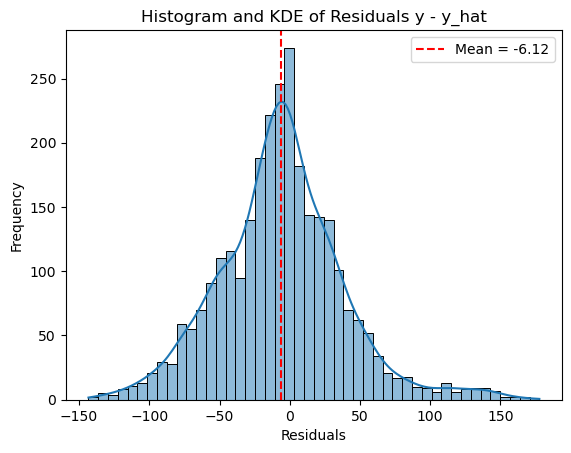

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

y_true = merged_df['price_dm']
y_pred = merged_df['mean']
residuals = y_true - y_pred

sns.histplot(residuals, kde=True)
plt.axvline(residuals.mean(), color='r', linestyle='--', label=f'Mean = {residuals.mean():.2f}')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram and KDE of Residuals y - y_hat')
plt.legend()
plt.show()


In [71]:
rmse_value = rmse(y_true, y_pred)
mape_value = mape(y_true, y_pred)
smape_value = smape(y_true, y_pred)

print("RMSE:", round(rmse_value, 2))
# print("MAPE:", round(mape_value, 2))
print("SMAPE:", round(smape_value, 2))

# Mine
# RMSE: 45.99
# SMAPE: 31.02

#Baseline
# RMSE: 41.18
# SMAPE: 25.75

RMSE: 44.8
SMAPE: 31.78


In [42]:
# Choose a specific timestamp
timestamp_to_plot = '2023-04-17'

# Filter both dataframes for the chosen timestamp
ets_preds_filtered = ets_pred[timestamp_to_plot]
dm_hour_filtered = dm_hour[timestamp_to_plot]

ets_preds_filtered.head()

,mean,pi_lower,pi_upper
2023-04-17 00:00:00,102.016184,71.774306,144.825288
2023-04-17 01:00:00,100.306159,62.068036,161.728039
2023-04-17 02:00:00,100.081153,55.986568,178.294871
2023-04-17 03:00:00,120.293451,61.848231,233.089346
2023-04-17 04:00:00,156.193179,74.585477,325.910624


In [43]:
import plotly.express as px
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Line(x=ets_preds_filtered.index, y=ets_preds_filtered['mean'], name='ETS Preds'))
fig.add_trace(go.Line(x=dm_hour_filtered.index, y=dm_hour_filtered['price_dm'], name='DM Hour'))
fig.update_layout(title='ETS Preds and DM Hour at {}'.format(timestamp_to_plot))
fig.show()



/home/m/miniconda3/envs/ThinkBayes2/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


